In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import sys
import os
import yaml
import matplotlib.pyplot as plt

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))

import logging
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
import backtrader as bt

In [7]:
class Strategies:
    """This class implements simple technical analysis strategies
    
    Strategy 1: Simple MA strategy based on the crossover of a short-term and a long-term moving average.
    Strategy 2: 
    Strategy 3: Mean Reversion strategy. Buy stocks whenever 2-period RSI closes below 5 and stock price is above its 200-day SMA
    
    """
    def __init__(self,df):
        self.df = df.copy()
        
    def Strategy1(self):
        self.df['strategy_1_position'] = 0

        # 1 if SMA50 > SMA200 (Buy signal)
        # -1 if SMA50 < SMA200 (Sell signal)
        self.df['signal'] = np.where(self.df['sma_50'] > self.df['sma_200'], 1, -1)

        # Only update position when signal changes (diff), otherwise hold
        self.df['strategy_1_position'] = self.df['signal'].diff().fillna(0).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

        # Forward-fill the position, holding until the next signal
        self.df['strategy_1_position'] = self.df['strategy_1_position'].replace(0, np.nan).ffill().fillna(0)

        # Calculate returns
        self.df['strategy_1_return'] = self.df['strategy_1_position'].shift(1) * self.df['return']
        self.df['strategy_1_cum_ret'] = (1 + self.df['strategy_1_return']).cumprod()

        self.df['strategy_1_sharpe'] = self.df['strategy_1_return'].rolling(252).mean() / self.df['strategy_1_return'].rolling(252).std()
        
        return self
  
    
    def Strategy2(self):
        self.df['strategy_2_position'] = 0

        # 1 for long: (close < lower_band) & (IBS < 0.3)
        # -1 for short: (close > high of previous day) or (close < sma_300)
        self.df['signal'] = np.where((self.df['close'] < self.df['lower_band']) & (self.df['IBS'] < 0.3), 1,
                        np.where((self.df['close'] > self.df['high'].shift(1)) | (self.df['close'] < self.df['sma_300']), -1, 0))

        # Only update position when signal changes (diff), otherwise hold
        self.df['strategy_2_position'] = self.df['signal'].diff().fillna(0).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

        # Forward-fill the position, holding until the next signal
        self.df['strategy_2_position'] = self.df['strategy_2_position'].replace(0, np.nan).ffill().fillna(0)

        #Calculate returns
        self.df['strategy_2_return'] = self.df['strategy_2_position'].shift(1) * self.df['return']
        self.df['strategy_2_cum_ret'] = (1 + self.df['strategy_2_return']).cumprod()

        return self

    
    def Strategy3(self):
        
        self.df['strategy_3_position'] = 0
        entry_signal = (self.df['RSI_2'].shift(1) < 5) & (self.df['close'] > self.df['sma_200'])
        holding_period = 5
        positions = np.zeros(len(self.df))
        entry_indices = np.where(entry_signal)[0]
        
        for entry_index in entry_indices:
            end_index = min(entry_index + holding_period, len(self.df))  
            positions[entry_index:end_index] = 1  

        self.df['strategy_3_position'] = positions  

    
        self.df['strategy_3_return'] = self.df['strategy_3_position'].shift(1) * self.df['return']
        self.df['strategy_3_cum_ret'] = (1 + self.df['strategy_3_return']).cumprod()


        return self
    
    def Strategy4(self):
        
        self.df['strategy_4_position'] = 0
        entry_signal = (self.df['RSI_2'].shift(1) < 5)
        positions = np.zeros(len(self.df))
        entry_indices = np.where(entry_signal)[0]
        
        for entry_index in entry_indices:
            for idx in range(entry_index, len(self.df)):
                if self.df['close'].iloc[idx] > self.df['sma_200'].shift(1).iloc[idx]:
                    break
                positions[idx] = 1

        self.df['strategy_4_position'] = positions  

        self.df['strategy_4_return'] = self.df['strategy_4_position'].shift(1) * self.df['return']
        self.df['strategy_4_cum_ret'] = (1 + self.df['strategy_4_return']).cumprod()

        return self

    
    def applying_strategies(self):
        self.Strategy1()
        self.Strategy2()
        self.Strategy3()
        self.Strategy4()
        self.df.dropna(inplace=True) 
        return self.df
    
    

In [8]:
#Getting hourly data from SQL

tickers = ['AAPL', 'MSFT', 'DIS', 'JPM']
data_dict = Pipeline(tickers).pipeline(timespan = 'hour')

In [9]:
#Applying the strategies
results_dict = {}

for ticker, df in data_dict.items():
    
    strategy = Strategies(df)
    df_strategies = strategy.applying_strategies()
    
    results_dict[ticker] = df_strategies

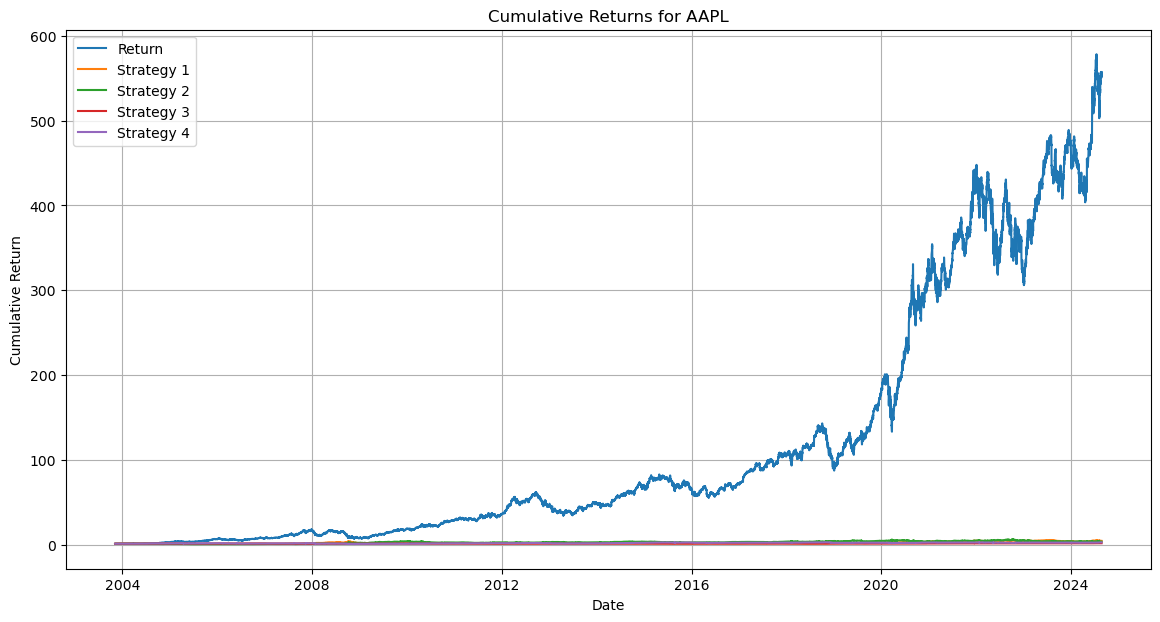

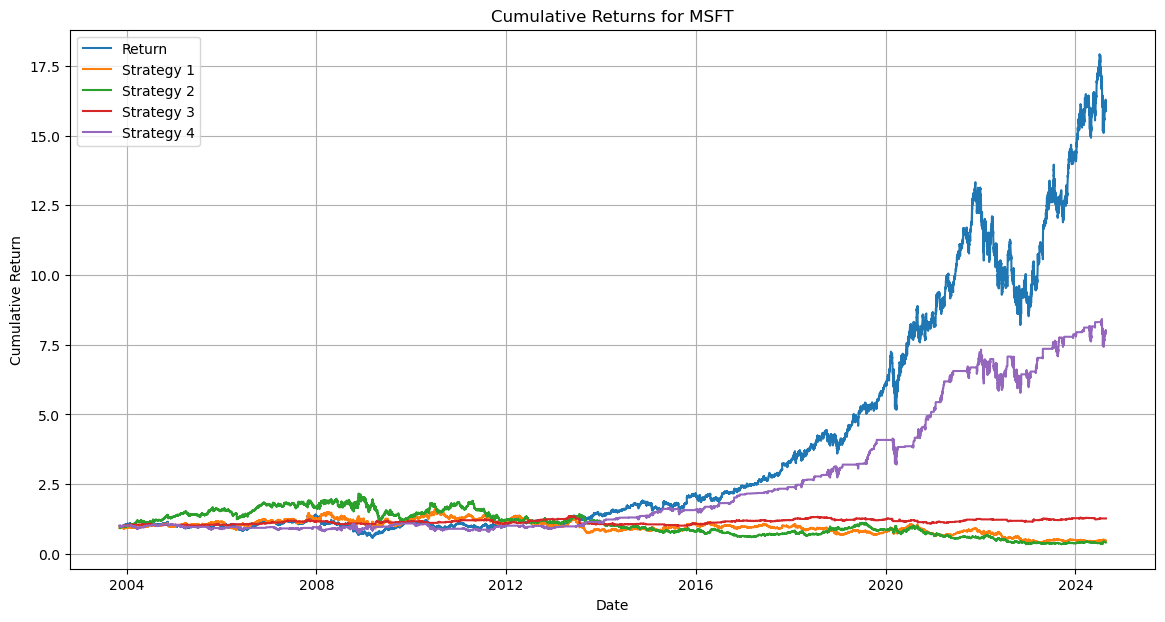

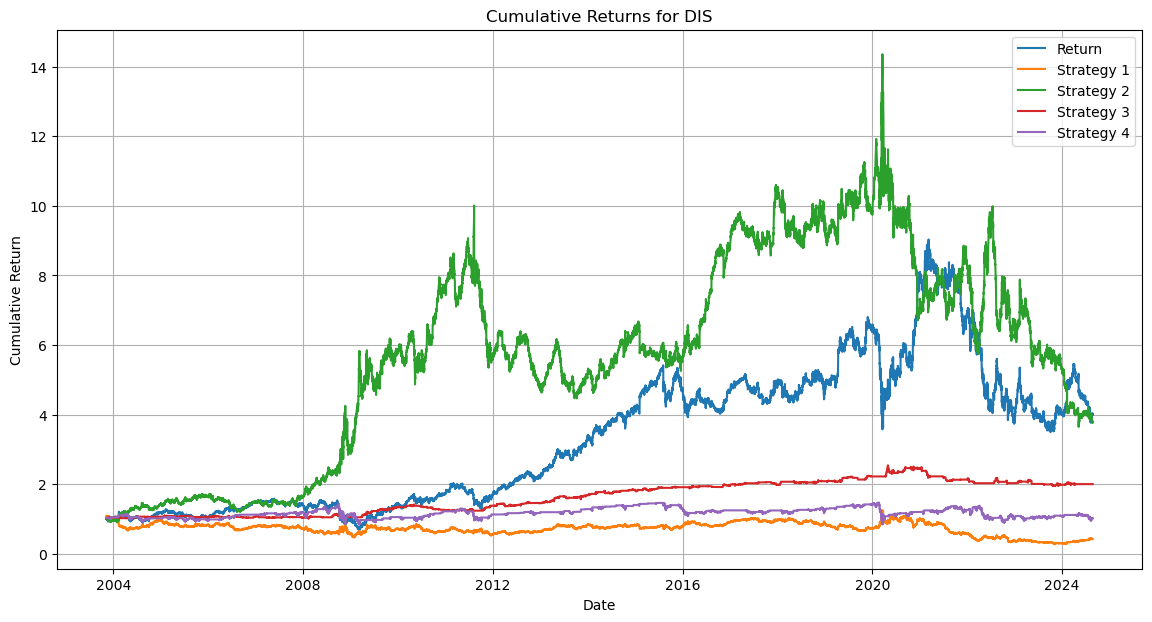

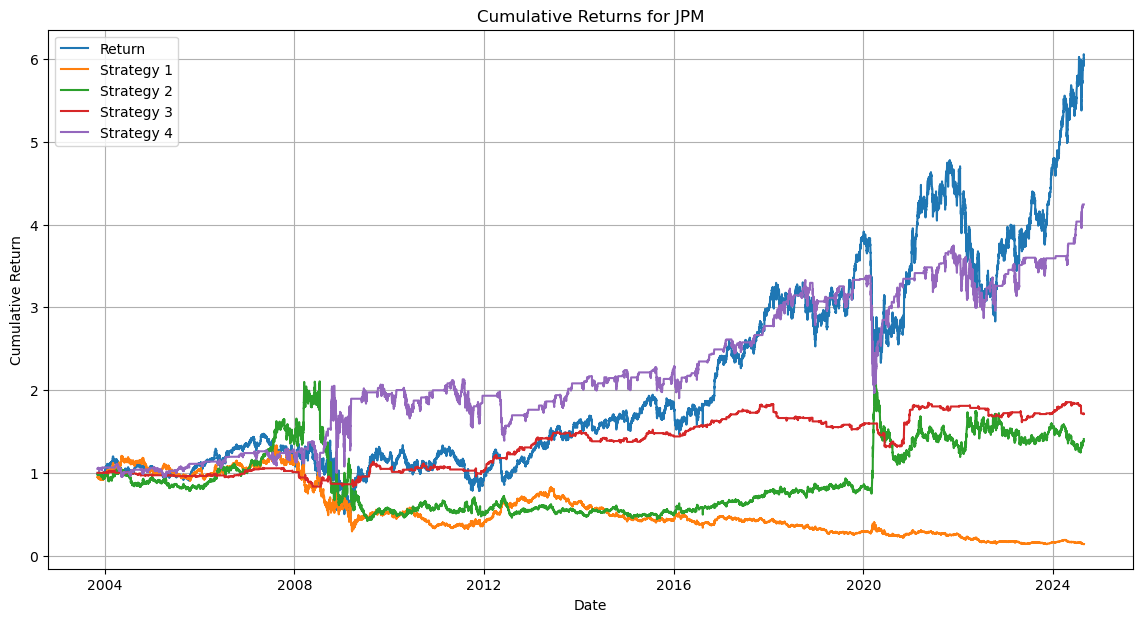

In [10]:

for ticker, df in results_dict.items():
    plt.figure(figsize=(14, 7))
    plt.title(f"Cumulative Returns for {ticker}")
    
    df['cum_return'] = (1 + df['return']).cumprod()
    
    plt.plot(df.index, df['cum_return'], label='Return')
    plt.plot(df.index, df['strategy_1_cum_ret'], label='Strategy 1')
    plt.plot(df.index, df['strategy_2_cum_ret'], label='Strategy 2')
    plt.plot(df.index, df['strategy_3_cum_ret'], label='Strategy 3')
    plt.plot(df.index, df['strategy_4_cum_ret'], label='Strategy 4')
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    plt.show()
